## Importing libraries and PFR geometry

In [1]:
import numpy as np
import math
from PDESystems.pfr_pde import PfrIpoptEnv
import torch
from Encoders.pca_model import PcaWarmLibrary
from Encoders.autoencoder import AeWarmLibrary, PrimalsAutoencoder
from Encoders.variational_autoncoder import VaeWarmLibrary, PrimalsVAE
from Encoders.regressor_train import LatentRegressor
from SACAgent.sac_agent import SACAgent

In [2]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
D_tube = 0.126
A_t = math.pi * (D_tube / 2.0) ** 2

params = {
    # geometry
    "A_t":   A_t,

    # inlet
    "cA_in": 80.0,
    "cB_in": 0.0,
    "cC_in": 0.0,
    "T_in": 423.0,

    # kinetics
    "Rgas": 8.314,
    "k01": 0.1, # 1/h
    "E1": 33475.0, # J/mol
    "k02": 9.0e-7, # m^3/(mol*h)
    "E2": 75319.0, # J/mol

    # heats of reaction (exothermic)
    "dH1": -20.0e3, # J/mol
    "dH2": -60.0e3, # J/mol

    # heat transfer per volume + volumetric heat capacity
    "Ua": 8524.0 * 1e3, # J/(m^3*h*K)
    "rhoCp": 8.0e5, # J/(m^3*K)

    # MV bounds
    "F_min": 0.6,
    "F_max": 4.5,
    "Tj_min": 298.0,
    "Tj_max": 600.0,

    # path/safety bounds on Tr
    "T_lo": 280.0,
    "T_hi": 700.0,
}

In [4]:
# Coarse mesh
pca_env = PfrIpoptEnv(
    params=params,
    N=10,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=500,
)

# SAC and Reward Config

In [5]:
STATE_DIM = 19
ACTION_DIM = 5  # [a_warm, a_pca, a_mu, a_tol, a_atol]
ACTOR_LAYER_SIZES = [256, 256, 256, 256]
CRITIC_LAYER_SIZES = [256, 256, 256, 256]
BUFFER_CAPACITY = 200_000
ACTOR_LR = 1e-4
CRITIC_LR = 1e-4
ALPHA_LR = 1e-4
SMOOTHING_STD = 0.2
NOISE_CLIP = 0.5
GAMMA = 0.99
TAU = 0.01
MAX_ACTION = 1.0
POLICY_DELAY = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
STD_START = 0.2
STD_END = 0.01
STD_DECAY_RATE = 0.99995
STD_DECAY_MODE = "exp"

In [6]:
def make_sac_agent():
    return SACAgent(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        actor_hidden=ACTOR_LAYER_SIZES,
        critic_hidden=CRITIC_LAYER_SIZES,
        gamma=GAMMA,
        actor_lr=ACTOR_LR,
        critic_lr=CRITIC_LR,
        alpha_lr=ALPHA_LR,
        batch_size=BATCH_SIZE,
        max_action=MAX_ACTION,
        tau=TAU,
        buffer_size=BUFFER_CAPACITY,
        device=DEVICE,
        use_per=False,
    )

In [7]:
from EvalPlotting.eval_fns import *

# Loading encoder-decoder wrappers

In [8]:
# 1) Load library (PCA + scalers + Z_data)
pca_lib = PcaWarmLibrary.load(r"checkpoints\pca_warm_lib.joblib", coarse_env=pca_env)

# 2) Rebuild regressor with same dims
in_dim = pca_lib.feats.shape[1]
out_dim = pca_lib.Z_latent.shape[1]

pca_reg = LatentRegressor(in_dim=in_dim, out_dim=out_dim, hidden_dims=(64, 64))
state_dict = torch.load(r"checkpoints\pca_latent_regressor.pth", map_location=device)
pca_reg.load_state_dict(state_dict)
pca_reg.to(device).eval()

# 3) Attach regressor to library
pca_lib.attach_regressor(pca_reg, device=device)

In [9]:
# 1) load library
ae_lib = AeWarmLibrary.load(r"checkpoints\ae_warm_lib.joblib", coarse_env=pca_env)

# 2) rebuild AE model with same sizes
input_dim = ae_lib.scaler.mean_.shape[0]     # D (number of primals)
latent_dim = ae_lib.Z_latent.shape[1]        # r (latent dimension)

ae_model = PrimalsAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
ae_model.load_state_dict(torch.load(r"checkpoints\ae_model.pth", map_location=device))
ae_model.to(device).eval()

# 3) rebuild and attach regressor
in_dim = ae_lib.feats.shape[1]       # 3
out_dim = ae_lib.Z_latent.shape[1]   # r
ae_reg = LatentRegressor(in_dim=in_dim, out_dim=out_dim, hidden_dims=(64, 64))
ae_reg.load_state_dict(torch.load(r"checkpoints\ae_latent_regressor.pth", map_location=device))
ae_reg.to(device).eval()

ae_lib.attach_regressor(ae_reg, device=device)
ae_lib.attach_decoder(ae_model.decoder)

In [10]:
vae_lib = VaeWarmLibrary.load(r"checkpoints\vae_warm_lib.joblib", coarse_env=pca_env)

input_dim = vae_lib.scaler.mean_.shape[0]
latent_dim = vae_lib.Z_mu.shape[1]

vae_model = PrimalsVAE(in_dim=input_dim, latent_dim=latent_dim)
vae_model.load_state_dict(torch.load(r"checkpoints\vae_model.pth", map_location=device))
vae_model.to(device).eval()

in_dim = vae_lib.feats.shape[1]   # 3
out_dim = vae_lib.Z_mu.shape[1]   # latent_dim
vae_reg = LatentRegressor(in_dim=in_dim, out_dim=out_dim, hidden_dims=(64, 64))
vae_reg.load_state_dict(torch.load(r"checkpoints\vae_latent_regressor.pth", map_location=device))
vae_reg.to(device).eval()

vae_lib.attach_regressor(vae_reg, device=device)
vae_lib.attach_decoder(vae_model.decoder)

[VAE LIB] Loaded from checkpoints\vae_warm_lib.joblib, feats shape=(5000, 3), X_recon shape=(5000, 966)


## Evaluating

In [11]:
rng = np.random.default_rng(123)
setpoints_eval = rng.uniform(20.0, 55.0, size=25)

# ----- baselines (no RL) -----
env_cold = PfrIpoptEnv(
    params=params,
    N=10, K=20,
    L=20.0, dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=500,
    pca_lib=None,
)

env_warm = PfrIpoptEnv(
    params=params,
    N=10, K=20,
    L=20.0, dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=500,
    pca_lib=None,
)

print("Evaluating cold baseline...")
cold_stats = eval_policy_on_setpoints_full(env_cold, agent=None,
                                           setpoints=setpoints_eval,
                                           mode="cold")
print("Evaluating warm baseline...")
warm_stats = eval_policy_on_setpoints_full(env_warm, agent=None,
                                           setpoints=setpoints_eval,
                                           mode="warm")

Evaluating cold baseline...
Evaluating warm baseline...


In [12]:
def eval_sac_variant(label, agent_path, pca_lib_for_env=None):
    """
    label: string name ("SAC-no-optimal", "SAC-PCA", "SAC-AE", "SAC-VAE")
    agent_path: path to saved SAC .pkl
    pca_lib_for_env: None, pca_lib, ae_lib, or vae_lib
    """
    print(f"\n=== Evaluating SAC variant: {label} ===")
    # ----- rebuild agent and load weights -----
    sac_agent = make_sac_agent()
    sac_agent.load(agent_path, load_optim=False)  # adjust if your load signature differs

    # ----- build RL env with correct library -----
    env_rl = PfrIpoptEnv(
        params=params,
        N=10, K=20,
        L=20.0, dt=0.02,
        target_species="B",
        n_zones=5,
        max_iter=500,
        pca_lib=pca_lib_for_env,
    )

    t0 = time.time()
    rl_stats = eval_policy_on_setpoints_full(env_rl, sac_agent,
                                             setpoints=setpoints_eval,
                                             mode="rl")
    t1 = time.time()
    print(f"{label}: eval wall-time = {t1 - t0:.1f} s")
    print(f"{label}: mean iters = {rl_stats['iters'].mean():.1f}, "
          f"mean time = {rl_stats['solve_time'].mean():.3f} s")

    return rl_stats

In [13]:
rl_noopt_stats = eval_sac_variant(
    label="SAC-no-optimal",
    agent_path=r"checkpoints\sac_no_optimal_20251202_023108.pkl",
    pca_lib_for_env=None,
)

rl_pca_stats = eval_sac_variant(
    label="SAC-PCA",
    agent_path=r"checkpoints\sac_pca_20251202_025720.pkl",
    pca_lib_for_env=pca_lib,
)

rl_ae_stats = eval_sac_variant(
    label="SAC-AE",
    agent_path=r"checkpoints\sac_ae_20251202_032400.pkl",
    pca_lib_for_env=ae_lib,
)

rl_vae_stats = eval_sac_variant(
    label="SAC-VAE",
    agent_path=r"checkpoints\sac_vae_20251202_035023.pkl",
    pca_lib_for_env=vae_lib,
)


=== Evaluating SAC variant: SAC-no-optimal ===
Agent loaded successfully from: checkpoints\sac_no_optimal_20251202_023108.pkl
SAC-no-optimal: eval wall-time = 7.4 s
SAC-no-optimal: mean iters = 18.4, mean time = 0.275 s

=== Evaluating SAC variant: SAC-PCA ===
Agent loaded successfully from: checkpoints\sac_pca_20251202_025720.pkl
SAC-PCA: eval wall-time = 5.8 s
SAC-PCA: mean iters = 13.7, mean time = 0.207 s

=== Evaluating SAC variant: SAC-AE ===
Agent loaded successfully from: checkpoints\sac_ae_20251202_032400.pkl
SAC-AE: eval wall-time = 5.6 s
SAC-AE: mean iters = 13.9, mean time = 0.202 s

=== Evaluating SAC variant: SAC-VAE ===
Agent loaded successfully from: checkpoints\sac_vae_20251202_035023.pkl
SAC-VAE: eval wall-time = 5.5 s
SAC-VAE: mean iters = 12.6, mean time = 0.196 s


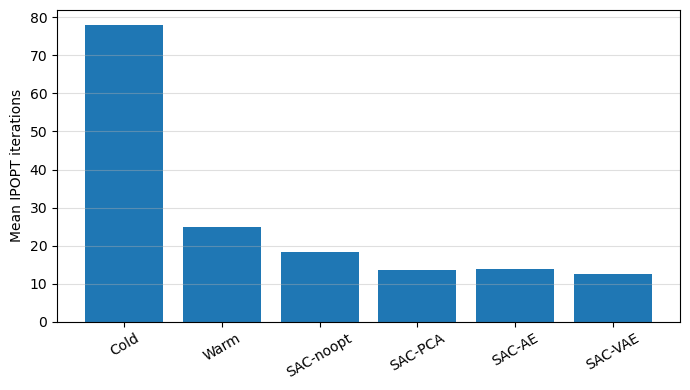

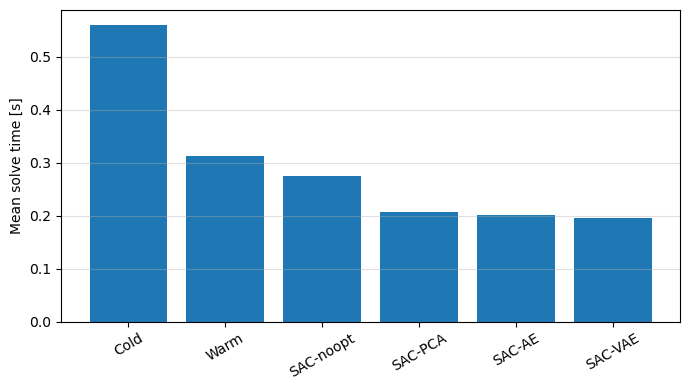

In [14]:
import matplotlib.pyplot as plt
labels = ["Cold", "Warm", "SAC-noopt", "SAC-PCA", "SAC-AE", "SAC-VAE"]

mean_iters = [
    cold_stats["iters"].mean(),
    warm_stats["iters"].mean(),
    rl_noopt_stats["iters"].mean(),
    rl_pca_stats["iters"].mean(),
    rl_ae_stats["iters"].mean(),
    rl_vae_stats["iters"].mean(),
]

mean_time = [
    cold_stats["solve_time"].mean(),
    warm_stats["solve_time"].mean(),
    rl_noopt_stats["solve_time"].mean(),
    rl_pca_stats["solve_time"].mean(),
    rl_ae_stats["solve_time"].mean(),
    rl_vae_stats["solve_time"].mean(),
]

x = np.arange(len(labels))

plt.figure(figsize=(7, 4))
plt.bar(x, mean_iters)
plt.xticks(x, labels, rotation=30)
plt.ylabel("Mean IPOPT iterations")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()

plt.figure(figsize=(7, 4))
plt.bar(x, mean_time)
plt.xticks(x, labels, rotation=30)
plt.ylabel("Mean solve time [s]")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()


In [15]:
def rel_improvement(new, base):
    return 100.0 * (base - new) / base

for name, s in [
    ("SAC-noopt", rl_noopt_stats),
    ("SAC-PCA",   rl_pca_stats),
    ("SAC-AE",    rl_ae_stats),
    ("SAC-VAE",   rl_vae_stats),
]:
    mi = s["iters"].mean()
    mt = s["solve_time"].mean()
    print(f"{name}: "
          f"iters {mi:.1f} ({rel_improvement(mi, warm_stats['iters'].mean()):+.1f}% vs warm), "
          f"time {mt:.3f}s ({rel_improvement(mt, warm_stats['solve_time'].mean()):+.1f}% vs warm)")


SAC-noopt: iters 18.4 (+26.0% vs warm), time 0.275s (+12.3% vs warm)
SAC-PCA: iters 13.7 (+44.8% vs warm), time 0.207s (+33.9% vs warm)
SAC-AE: iters 13.9 (+44.1% vs warm), time 0.202s (+35.5% vs warm)
SAC-VAE: iters 12.6 (+49.3% vs warm), time 0.196s (+37.4% vs warm)


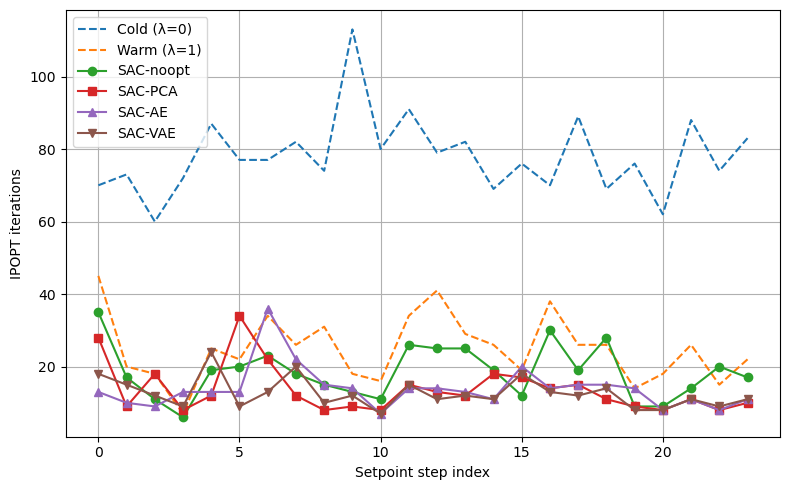

In [16]:
steps = np.arange(rl_noopt_stats["iters"].size)

plt.figure(figsize=(8, 5))
plt.plot(steps, cold_stats["iters"],    "--", label="Cold (λ=0)")
plt.plot(steps, warm_stats["iters"],    "--", label="Warm (λ=1)")
plt.plot(steps, rl_noopt_stats["iters"], marker="o", label="SAC-noopt")
plt.plot(steps, rl_pca_stats["iters"],  marker="s", label="SAC-PCA")
plt.plot(steps, rl_ae_stats["iters"],   marker="^", label="SAC-AE")
plt.plot(steps, rl_vae_stats["iters"],  marker="v", label="SAC-VAE")
plt.xlabel("Setpoint step index")
plt.ylabel("IPOPT iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()


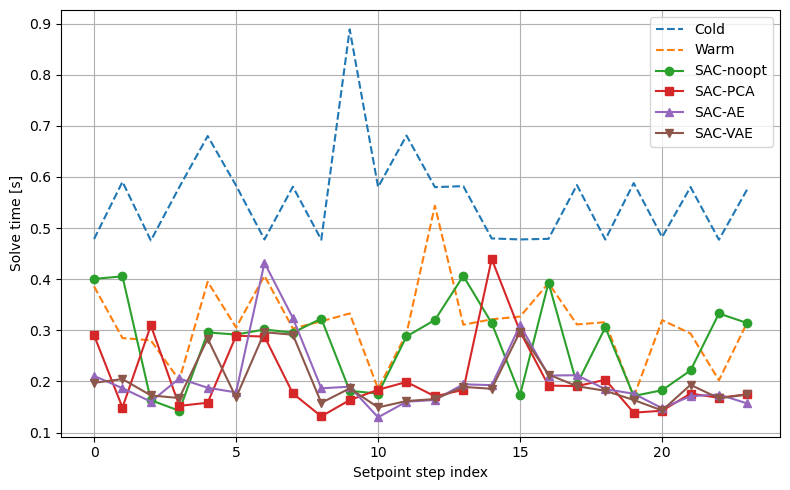

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(steps, cold_stats["solve_time"],    "--", label="Cold")
plt.plot(steps, warm_stats["solve_time"],    "--", label="Warm")
plt.plot(steps, rl_noopt_stats["solve_time"], marker="o", label="SAC-noopt")
plt.plot(steps, rl_pca_stats["solve_time"],  marker="s", label="SAC-PCA")
plt.plot(steps, rl_ae_stats["solve_time"],   marker="^", label="SAC-AE")
plt.plot(steps, rl_vae_stats["solve_time"],  marker="v", label="SAC-VAE")
plt.xlabel("Setpoint step index")
plt.ylabel("Solve time [s]")
plt.legend()
plt.grid(True)
plt.tight_layout()

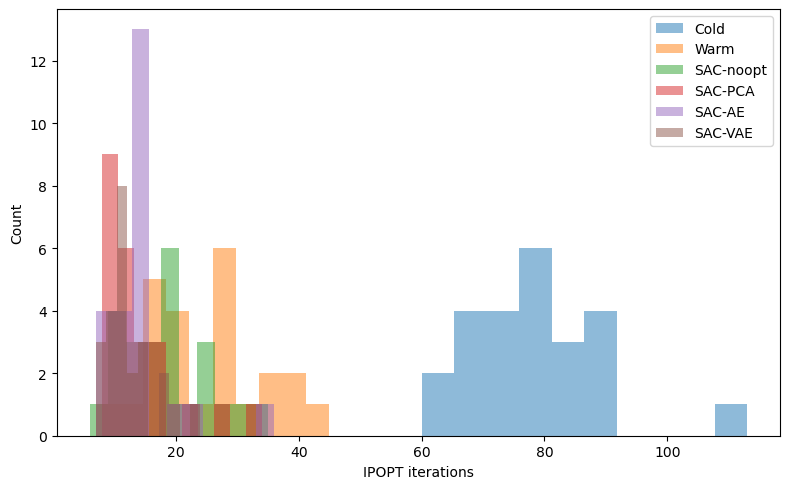

In [18]:
plt.figure(figsize=(8, 5))
bins = 10

plt.hist(cold_stats["iters"],    bins=bins, alpha=0.5, label="Cold")
plt.hist(warm_stats["iters"],    bins=bins, alpha=0.5, label="Warm")
plt.hist(rl_noopt_stats["iters"], bins=bins, alpha=0.5, label="SAC-noopt")
plt.hist(rl_pca_stats["iters"],   bins=bins, alpha=0.5, label="SAC-PCA")
plt.hist(rl_ae_stats["iters"],    bins=bins, alpha=0.5, label="SAC-AE")
plt.hist(rl_vae_stats["iters"],   bins=bins, alpha=0.5, label="SAC-VAE")

plt.xlabel("IPOPT iterations")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

C:\Users\HAMEDI\AppData\Local\Temp\ipykernel_23608\1897081449.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_iters, labels=labels, showmeans=True)


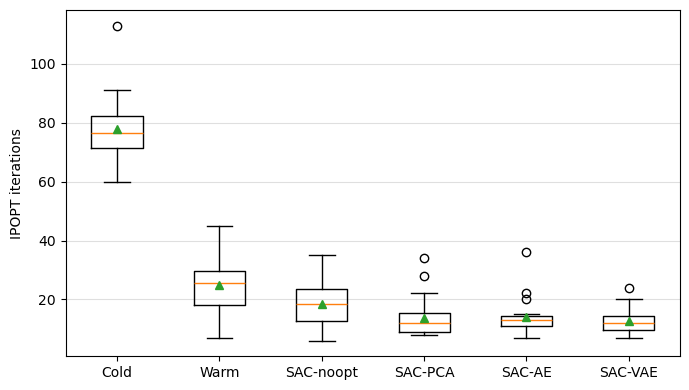

In [19]:
data_iters = [
    cold_stats["iters"],
    warm_stats["iters"],
    rl_noopt_stats["iters"],
    rl_pca_stats["iters"],
    rl_ae_stats["iters"],
    rl_vae_stats["iters"],
]

plt.figure(figsize=(7, 4))
plt.boxplot(data_iters, labels=labels, showmeans=True)
plt.ylabel("IPOPT iterations")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()

In [20]:
print("Mean L2 tracking error:")
print(f"Cold : {cold_stats['l2'].mean():.3e}")
print(f"Warm : {warm_stats['l2'].mean():.3e}")
print(f"SAC-noopt : {rl_noopt_stats['l2'].mean():.3e}")
print(f"SAC-PCA   : {rl_pca_stats['l2'].mean():.3e}")
print(f"SAC-AE    : {rl_ae_stats['l2'].mean():.3e}")
print(f"SAC-VAE   : {rl_vae_stats['l2'].mean():.3e}")

Mean L2 tracking error:
Cold : 2.018e+00
Warm : 2.018e+00
SAC-noopt : 2.018e+00
SAC-PCA   : 2.018e+00
SAC-AE    : 2.015e+00
SAC-VAE   : 2.020e+00


## Evaluating on fine grid

In [32]:
rng = np.random.default_rng(123)
setpoints_eval = rng.uniform(20.0, 55.0, size=25)

# ----- baselines (no RL) -----
env_cold = PfrIpoptEnv(
    params=params,
    N=30, K=20,
    L=20.0, dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=500,
    pca_lib=None,
)

env_warm = PfrIpoptEnv(
    params=params,
    N=30, K=20,
    L=20.0, dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=500,
    pca_lib=None,
)

print("Evaluating cold baseline...")
cold_stats = eval_policy_on_setpoints_full(env_cold, agent=None,
                                           setpoints=setpoints_eval,
                                           mode="cold")
print("Evaluating warm baseline...")
warm_stats = eval_policy_on_setpoints_full(env_warm, agent=None,
                                           setpoints=setpoints_eval,
                                           mode="warm")

Evaluating cold baseline...
Evaluating warm baseline...


In [33]:
def eval_sac_variant(label, agent_path, pca_lib_for_env=None):
    """
    label: string name ("SAC-no-optimal", "SAC-PCA", "SAC-AE", "SAC-VAE")
    agent_path: path to saved SAC .pkl
    pca_lib_for_env: None, pca_lib, ae_lib, or vae_lib
    """
    print(f"\n=== Evaluating SAC variant: {label} ===")
    # ----- rebuild agent and load weights -----
    sac_agent = make_sac_agent()
    sac_agent.load(agent_path, load_optim=False)  # adjust if your load signature differs

    # ----- build RL env with correct library -----
    env_rl = PfrIpoptEnv(
        params=params,
        N=30, K=20,
        L=20.0, dt=0.02,
        target_species="B",
        n_zones=5,
        max_iter=500,
        pca_lib=pca_lib_for_env,
    )

    t0 = time.time()
    rl_stats = eval_policy_on_setpoints_full(env_rl, sac_agent,
                                             setpoints=setpoints_eval,
                                             mode="rl")
    t1 = time.time()
    print(f"{label}: eval wall-time = {t1 - t0:.1f} s")
    print(f"{label}: mean iters = {rl_stats['iters'].mean():.1f}, "
          f"mean time = {rl_stats['solve_time'].mean():.3f} s")

    return rl_stats

In [34]:
rl_noopt_stats = eval_sac_variant(
    label="SAC-no-optimal",
    agent_path=r"checkpoints\sac_no_optimal_20251202_023108.pkl",
    pca_lib_for_env=None,
)

rl_pca_stats = eval_sac_variant(
    label="SAC-PCA",
    agent_path=r"checkpoints\sac_pca_20251202_025720.pkl",
    pca_lib_for_env=pca_lib,
)

rl_ae_stats = eval_sac_variant(
    label="SAC-AE",
    agent_path=r"checkpoints\sac_ae_20251202_032400.pkl",
    pca_lib_for_env=ae_lib,
)

rl_vae_stats = eval_sac_variant(
    label="SAC-VAE",
    agent_path=r"checkpoints\sac_vae_20251202_035023.pkl",
    pca_lib_for_env=vae_lib,
)


=== Evaluating SAC variant: SAC-no-optimal ===
Agent loaded successfully from: checkpoints\sac_no_optimal_20251202_023108.pkl
SAC-no-optimal: eval wall-time = 148.8 s
SAC-no-optimal: mean iters = 112.4, mean time = 6.011 s

=== Evaluating SAC variant: SAC-PCA ===
Agent loaded successfully from: checkpoints\sac_pca_20251202_025720.pkl
SAC-PCA: eval wall-time = 65.6 s
SAC-PCA: mean iters = 54.0, mean time = 2.554 s

=== Evaluating SAC variant: SAC-AE ===
Agent loaded successfully from: checkpoints\sac_ae_20251202_032400.pkl
SAC-AE: eval wall-time = 52.4 s
SAC-AE: mean iters = 38.8, mean time = 2.001 s

=== Evaluating SAC variant: SAC-VAE ===
Agent loaded successfully from: checkpoints\sac_vae_20251202_035023.pkl
SAC-VAE: eval wall-time = 52.0 s
SAC-VAE: mean iters = 33.5, mean time = 1.992 s


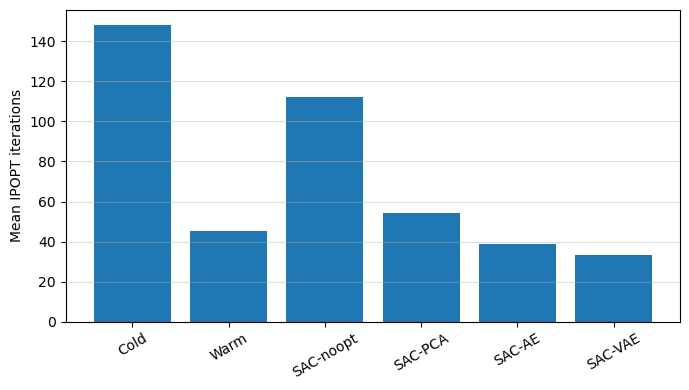

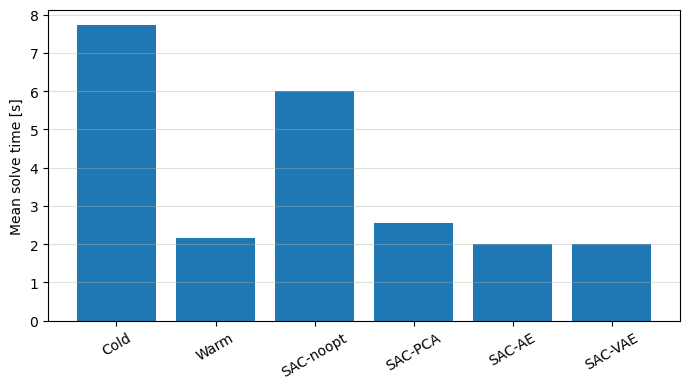

In [35]:
import matplotlib.pyplot as plt
labels = ["Cold", "Warm", "SAC-noopt", "SAC-PCA", "SAC-AE", "SAC-VAE"]

mean_iters = [
    cold_stats["iters"].mean(),
    warm_stats["iters"].mean(),
    rl_noopt_stats["iters"].mean(),
    rl_pca_stats["iters"].mean(),
    rl_ae_stats["iters"].mean(),
    rl_vae_stats["iters"].mean(),
]

mean_time = [
    cold_stats["solve_time"].mean(),
    warm_stats["solve_time"].mean(),
    rl_noopt_stats["solve_time"].mean(),
    rl_pca_stats["solve_time"].mean(),
    rl_ae_stats["solve_time"].mean(),
    rl_vae_stats["solve_time"].mean(),
]

x = np.arange(len(labels))

plt.figure(figsize=(7, 4))
plt.bar(x, mean_iters)
plt.xticks(x, labels, rotation=30)
plt.ylabel("Mean IPOPT iterations")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()

plt.figure(figsize=(7, 4))
plt.bar(x, mean_time)
plt.xticks(x, labels, rotation=30)
plt.ylabel("Mean solve time [s]")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()


In [36]:
def rel_improvement(new, base):
    return 100.0 * (base - new) / base

for name, s in [
    ("SAC-noopt", rl_noopt_stats),
    ("SAC-PCA",   rl_pca_stats),
    ("SAC-AE",    rl_ae_stats),
    ("SAC-VAE",   rl_vae_stats),
]:
    mi = s["iters"].mean()
    mt = s["solve_time"].mean()
    print(f"{name}: "
          f"iters {mi:.1f} ({rel_improvement(mi, warm_stats['iters'].mean()):+.1f}% vs warm), "
          f"time {mt:.3f}s ({rel_improvement(mt, warm_stats['solve_time'].mean()):+.1f}% vs warm)")


SAC-noopt: iters 112.4 (-147.3% vs warm), time 6.011s (-179.6% vs warm)
SAC-PCA: iters 54.0 (-18.9% vs warm), time 2.554s (-18.8% vs warm)
SAC-AE: iters 38.8 (+14.8% vs warm), time 2.001s (+6.9% vs warm)
SAC-VAE: iters 33.5 (+26.4% vs warm), time 1.992s (+7.3% vs warm)


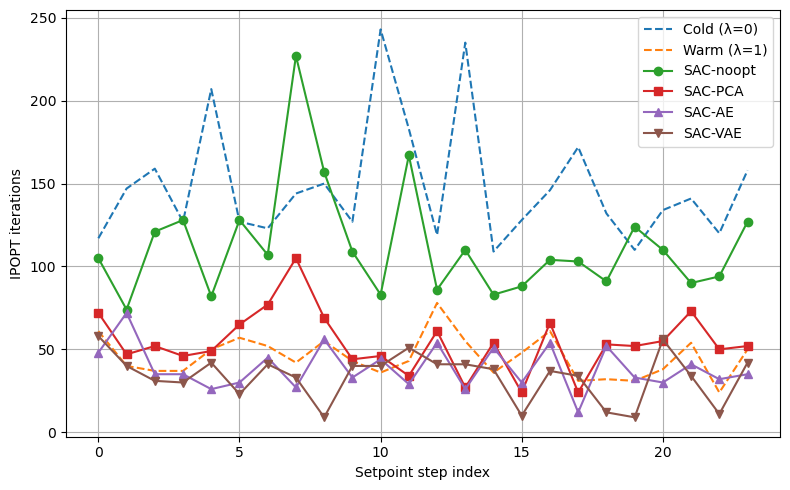

In [37]:
steps = np.arange(rl_noopt_stats["iters"].size)

plt.figure(figsize=(8, 5))
plt.plot(steps, cold_stats["iters"],    "--", label="Cold (λ=0)")
plt.plot(steps, warm_stats["iters"],    "--", label="Warm (λ=1)")
plt.plot(steps, rl_noopt_stats["iters"], marker="o", label="SAC-noopt")
plt.plot(steps, rl_pca_stats["iters"],  marker="s", label="SAC-PCA")
plt.plot(steps, rl_ae_stats["iters"],   marker="^", label="SAC-AE")
plt.plot(steps, rl_vae_stats["iters"],  marker="v", label="SAC-VAE")
plt.xlabel("Setpoint step index")
plt.ylabel("IPOPT iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()


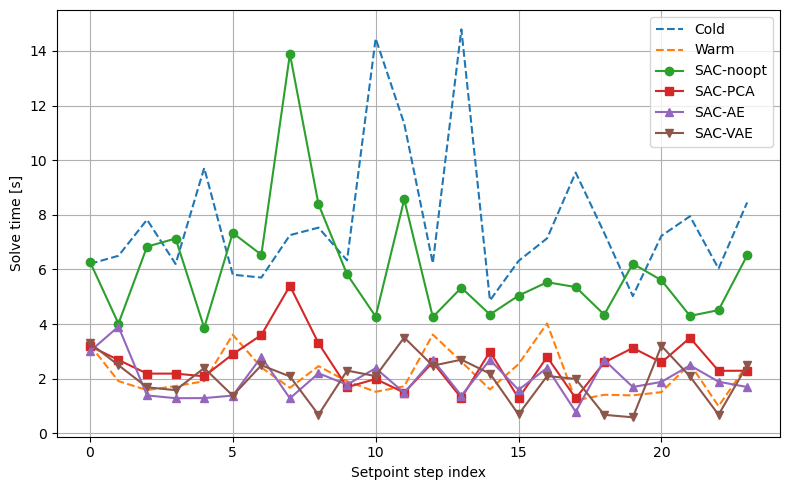

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(steps, cold_stats["solve_time"],    "--", label="Cold")
plt.plot(steps, warm_stats["solve_time"],    "--", label="Warm")
plt.plot(steps, rl_noopt_stats["solve_time"], marker="o", label="SAC-noopt")
plt.plot(steps, rl_pca_stats["solve_time"],  marker="s", label="SAC-PCA")
plt.plot(steps, rl_ae_stats["solve_time"],   marker="^", label="SAC-AE")
plt.plot(steps, rl_vae_stats["solve_time"],  marker="v", label="SAC-VAE")
plt.xlabel("Setpoint step index")
plt.ylabel("Solve time [s]")
plt.legend()
plt.grid(True)
plt.tight_layout()

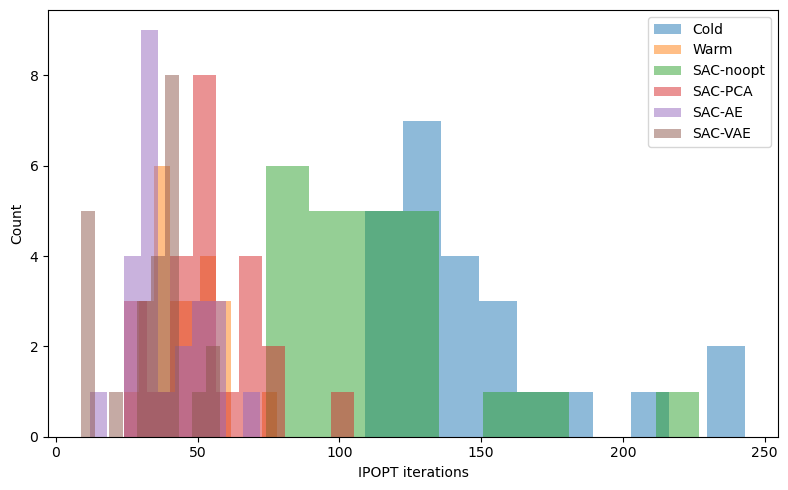

In [39]:
plt.figure(figsize=(8, 5))
bins = 10

plt.hist(cold_stats["iters"],    bins=bins, alpha=0.5, label="Cold")
plt.hist(warm_stats["iters"],    bins=bins, alpha=0.5, label="Warm")
plt.hist(rl_noopt_stats["iters"], bins=bins, alpha=0.5, label="SAC-noopt")
plt.hist(rl_pca_stats["iters"],   bins=bins, alpha=0.5, label="SAC-PCA")
plt.hist(rl_ae_stats["iters"],    bins=bins, alpha=0.5, label="SAC-AE")
plt.hist(rl_vae_stats["iters"],   bins=bins, alpha=0.5, label="SAC-VAE")

plt.xlabel("IPOPT iterations")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

C:\Users\HAMEDI\AppData\Local\Temp\ipykernel_23608\1897081449.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_iters, labels=labels, showmeans=True)


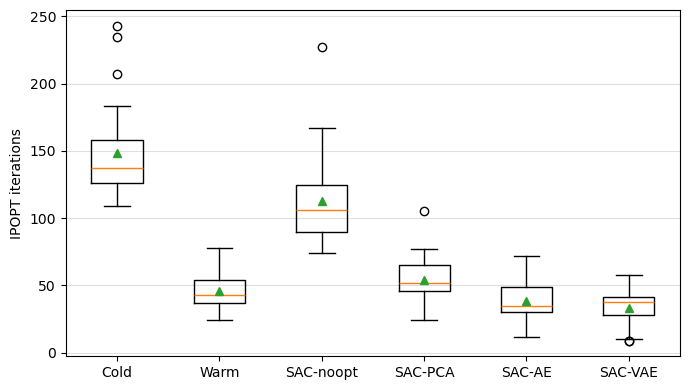

In [40]:
data_iters = [
    cold_stats["iters"],
    warm_stats["iters"],
    rl_noopt_stats["iters"],
    rl_pca_stats["iters"],
    rl_ae_stats["iters"],
    rl_vae_stats["iters"],
]

plt.figure(figsize=(7, 4))
plt.boxplot(data_iters, labels=labels, showmeans=True)
plt.ylabel("IPOPT iterations")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()

In [41]:
print("Mean L2 tracking error:")
print(f"Cold : {cold_stats['l2'].mean():.3e}")
print(f"Warm : {warm_stats['l2'].mean():.3e}")
print(f"SAC-noopt : {rl_noopt_stats['l2'].mean():.3e}")
print(f"SAC-PCA   : {rl_pca_stats['l2'].mean():.3e}")
print(f"SAC-AE    : {rl_ae_stats['l2'].mean():.3e}")
print(f"SAC-VAE   : {rl_vae_stats['l2'].mean():.3e}")

Mean L2 tracking error:
Cold : 2.437e+00
Warm : 2.544e+00
SAC-noopt : 2.516e+00
SAC-PCA   : 2.534e+00
SAC-AE    : 2.381e+00
SAC-VAE   : 2.344e+00
